# Fertilizer, fuels and grains

## Introduction

The are several material inputs for crops but fertilizers(inclusive of some crop chemicals), fuels and grains make up about 80% of most frequently purchased agricultural items.
We shall perform a time series analysis on each of the items individually as we try anitcipate their future prices.

## Data Understanding

### Data Source

The majority of our data is scrapped from [here](https://ycharts.com/indicators). The fertilizer and grains data have their unints as the consumer Price index (2010=100), more details [here](https://databank.worldbank.org/metadataglossary/jobs/series/FP.CPI.TOTL), while the fuels data is in a slightly different index of consumer price index (1982=100) with 1982 as the base year.



### Data overview

In [1]:
#Importing the relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller




Let us import the data sets: 

In [2]:
#Fertilizer data
df_fert = pd.read_csv("Fert_data.csv")


# # Convert the 'Date' column to datetime format
df_fert['Date'] = pd.to_datetime(df_fert['Date'], format="%d-%b-%y")
df_fert['Value'] = df_fert['Value'].astype(float)


df_fert.head()

,Date,Value
0,2023-12-31,119.36
1,2023-11-30,157.16
2,2023-10-31,161.78
3,2023-09-30,157.52
4,2023-08-31,157.58


In [3]:
# Grains data
#Fertilizer data
df_grains = pd.read_csv("Grains.csv")


# Convert the 'Date' column to datetime format
df_grains['Date'] = pd.to_datetime(df_grains['Date'], format='%d-%b-%y')
df_grains['Value'] = df_grains['Value'].astype(float)


df_grains.head()


,Date,Value
0,2023-12-31,122.65
1,2023-11-30,120.05
2,2023-10-31,125.53
3,2023-09-30,127.78
4,2023-08-31,125.33


In [4]:
#Fertilizer data
df_fuels = pd.read_csv("Fuels.csv")

# Convert the 'Date' column to datetime format
df_fuels['Date'] = pd.to_datetime(df_fuels['Date'], format='%d-%b-%y')
df_fuels['Value'] = df_fuels['Value'].astype(float)


df_fuels.head()

,Date,Value
0,2023-12-31,320.29
1,2023-11-30,369.78
2,2023-10-31,384.54
3,2023-09-30,420.69
4,2023-08-31,402.11


## EDA

### Univariate and Bivariate analysis

We shall look at the distribution of the value as well as how the value compares against the date.

<Figure size 864x432 with 0 Axes>

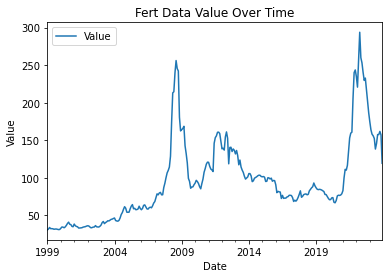

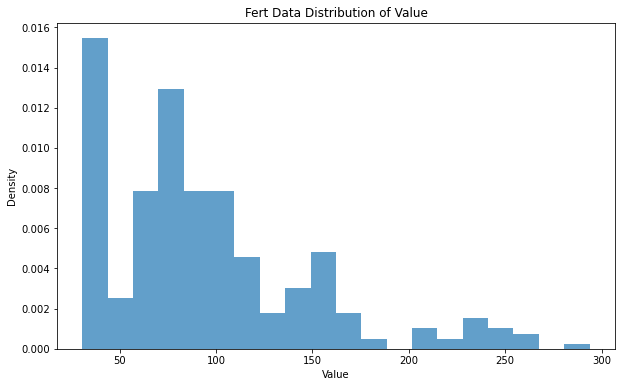

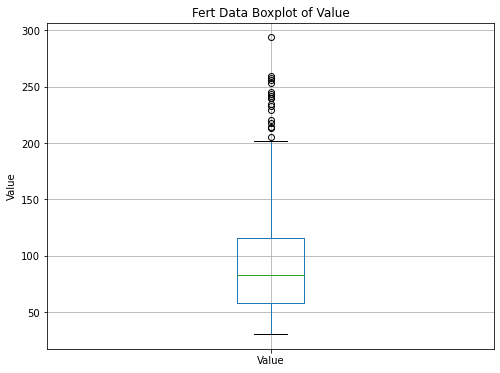

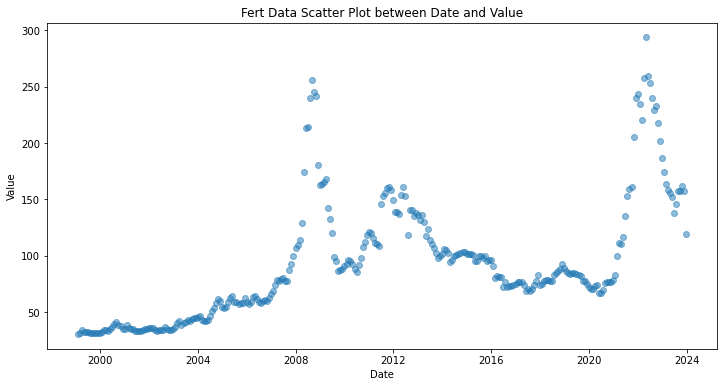

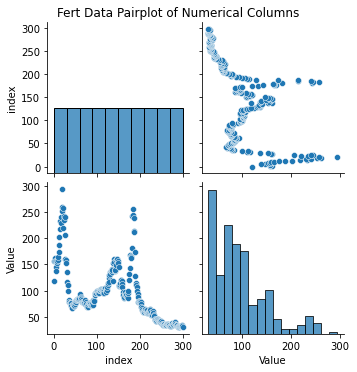

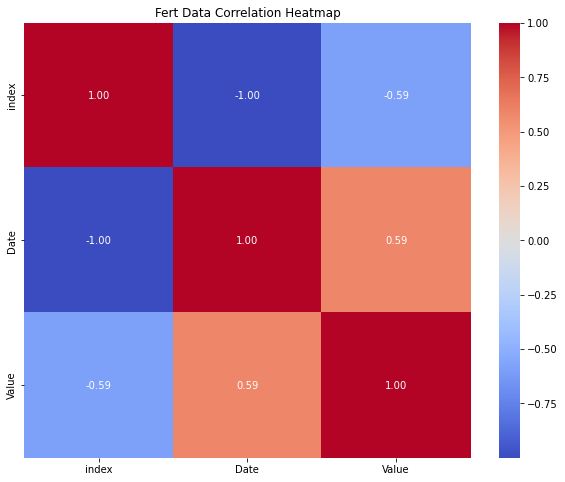

<Figure size 864x432 with 0 Axes>

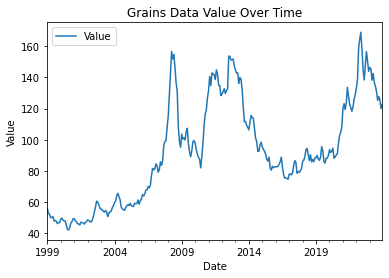

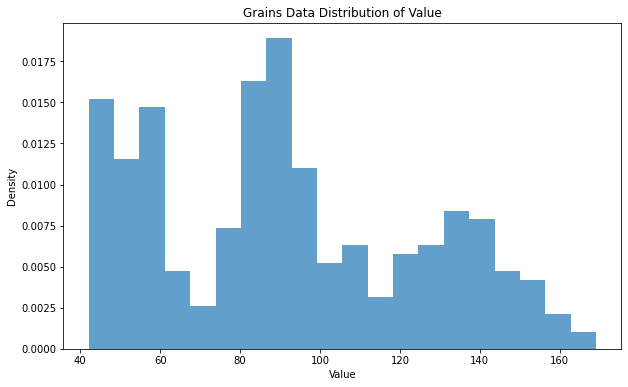

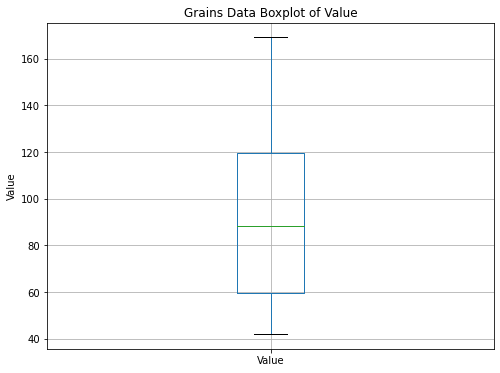

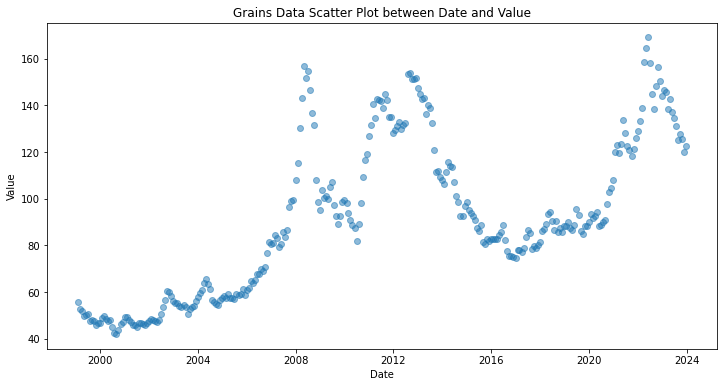

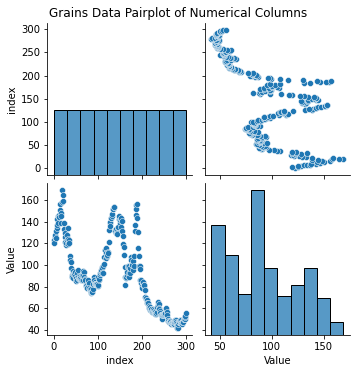

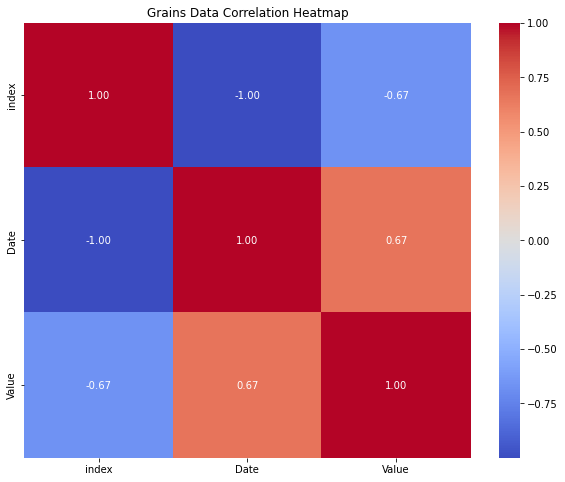

<Figure size 864x432 with 0 Axes>

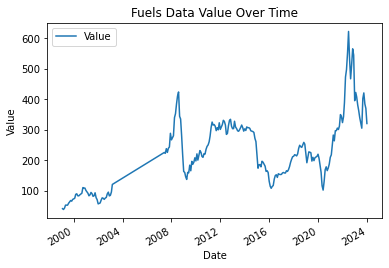

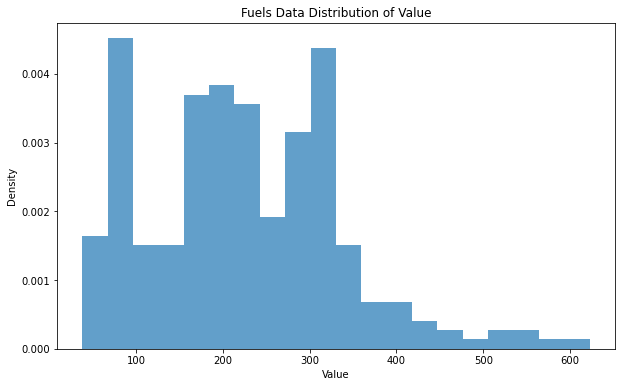

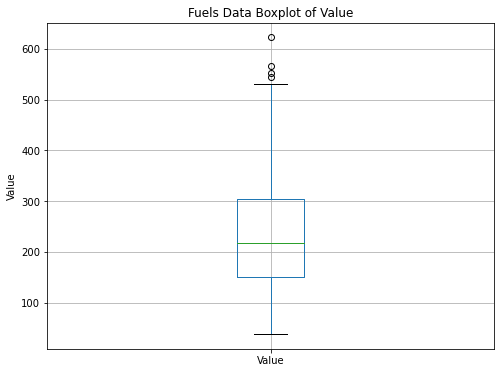

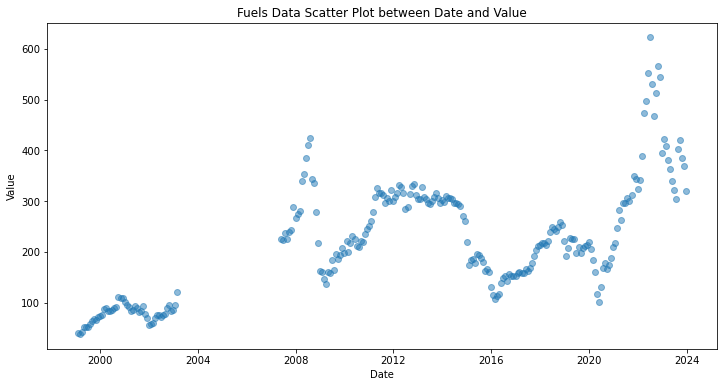

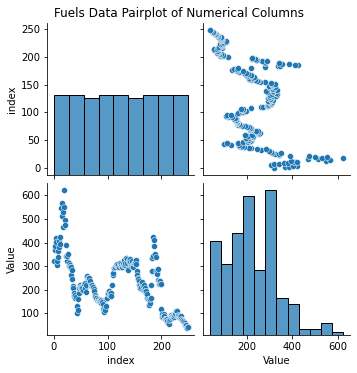

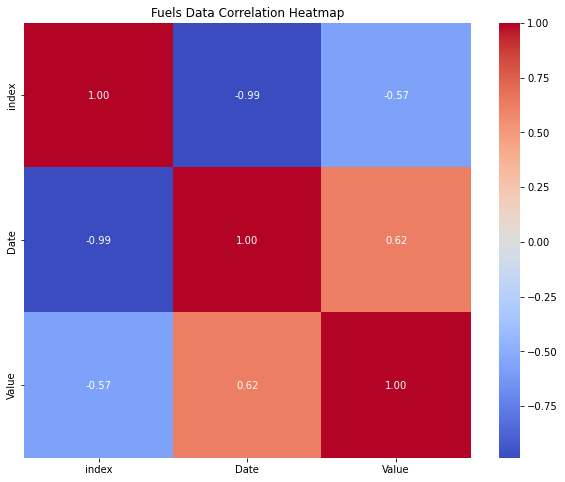

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to clean and process the dataframe
def process_dataframe(df):
    # Ensure 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y', errors='coerce')
    df = df.dropna(subset=['Date'])  # Drop rows with missing or invalid dates
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')  # Convert 'Value' to numeric
    return df

# Function to reset index and convert 'Date' to a regular column
def reset_and_convert_date(df):
    df_reset = df.reset_index()
    df_reset['Date'] = pd.to_datetime(df_reset['Date'])
    return df_reset

# Function to perform EDA and plot visualizations
def perform_eda(df, title_prefix):
    # Plot a line chart for the 'Value' column over time using pandas plot
    plt.figure(figsize=(12, 6))
    df.plot(x='Date', y='Value', kind='line')
    plt.title(f'{title_prefix} Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

    # Plot a distribution of the 'Value' column
    plt.figure(figsize=(10, 6))
    df['Value'].plot(kind='hist', bins=20, density=True, alpha=0.7)
    plt.title(f'{title_prefix} Distribution of Value')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()

    # Plot a boxplot of the 'Value' column
    plt.figure(figsize=(8, 6))
    df.boxplot(column='Value')
    plt.title(f'{title_prefix} Boxplot of Value')
    plt.ylabel('Value')
    plt.show()

    # Scatter plot between 'Date' and 'Value'
    plt.figure(figsize=(12, 6))
    plt.scatter(df['Date'], df['Value'], alpha=0.5)
    plt.title(f'{title_prefix} Scatter Plot between Date and Value')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

    # Pairplot to visualize relationships between numerical columns
    sns.pairplot(df)
    plt.suptitle(f'{title_prefix} Pairplot of Numerical Columns', y=1.02)
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'{title_prefix} Correlation Heatmap')
    plt.show()

# Load and process the first dataset
df1 = df_fert.copy()
df1 = process_dataframe(df1)
df1_reset = reset_and_convert_date(df1)
perform_eda(df1_reset, 'Fert Data')

# Load and process the second dataset
df2 = df_grains.copy()
df2 = process_dataframe(df2)
df2_reset = reset_and_convert_date(df2)
perform_eda(df2_reset, 'Grains Data')

# Load and process the third dataset
df3 = df_fuels.copy()
df3 = process_dataframe(df3)
df3_reset = reset_and_convert_date(df3)
perform_eda(df3_reset, 'Fuels Data')


### Multivariate analysis

Here we compare the different value variables with each other and how they collevtively relate to the date

In [6]:

df_analysis=pd.merge(df_fert,df_grains,on='Date')
df_analysis=pd.merge(df_analysis,df_fuels,on='Date')
df_analysis.rename(columns={'Value_x':'Fertilizer','Value_y':'Grains', 'Value':'Fuel'}, inplace = True)
df_analysis.head()

,Date,Fertilizer,Grains,Fuel
0,2023-12-31,119.36,122.65,320.29
1,2023-11-30,157.16,120.05,369.78
2,2023-10-31,161.78,125.53,384.54
3,2023-09-30,157.52,127.78,420.69
4,2023-08-31,157.58,125.33,402.11


In [8]:
# Set 'Date' as the index
df_analysis.set_index('Date', inplace=True)
df_yearly = df_analysis.resample('Y').sum()
df_yearly.reset_index(inplace=True)
df_yearly

,Date,Fertilizer,Grains,Fuel
0,1999-12-31,382.47,595.14,678.40
1,2000-12-31,433.41,559.73,1113.10
2,2001-12-31,418.35,562.72,1002.80
3,2002-12-31,419.08,635.27,915.20
4,2003-12-31,77.68,110.52,216.10
5,2004-12-31,0.00,0.00,0.00
6,2005-12-31,0.00,0.00,0.00
7,2006-12-31,0.00,0.00,0.00
8,2007-12-31,702.09,739.51,1948.10
9,2008-12-31,2281.03,1568.30,3804.50


There is some missing data between 2004-2006 so we shall drop all data prior to 2007

In [9]:
df_yearly.drop(index=5,inplace=True)
df_yearly.drop(index=6,inplace=True)
df_yearly.drop(index=7,inplace=True)
df_yearly.reset_index()
df_yearly= df_yearly.reset_index().drop(columns='index')
df_yearly.head()

,Date,Fertilizer,Grains,Fuel
0,1999-12-31,382.47,595.14,678.4
1,2000-12-31,433.41,559.73,1113.1
2,2001-12-31,418.35,562.72,1002.8
3,2002-12-31,419.08,635.27,915.2
4,2003-12-31,77.68,110.52,216.1


Basic Statistics:
                                Date   Fertilizer       Grains         Fuel
count                             22    22.000000    22.000000    22.000000
mean   2012-10-25 04:21:49.090909184  1164.966364  1111.095909  2548.419545
min              1999-12-31 00:00:00    77.680000   110.520000   216.100000
25%              2008-03-31 12:00:00   746.157500   796.272500  1725.050000
50%              2013-07-01 12:00:00  1085.470000  1105.830000  2331.200000
75%              2018-09-30 18:00:00  1598.665000  1525.745000  3615.962500
max              2023-12-31 00:00:00  2828.830000  1804.480000  5892.680000
std                              NaN   671.669867   447.786058  1384.711643


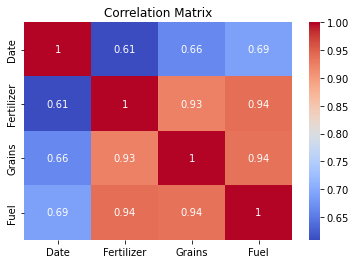

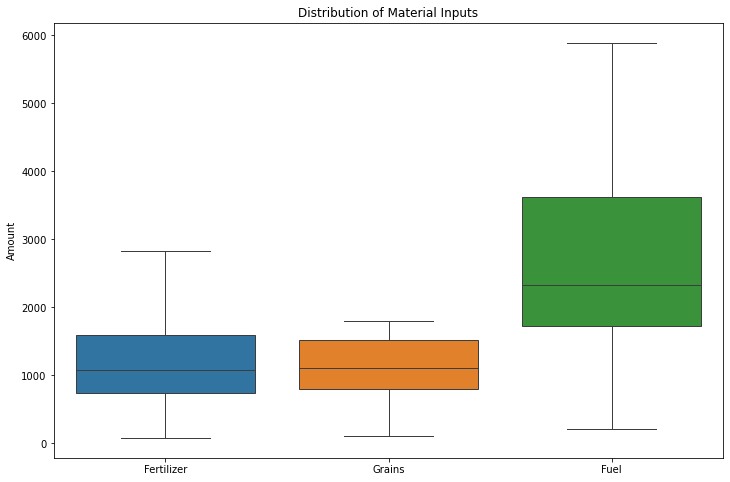

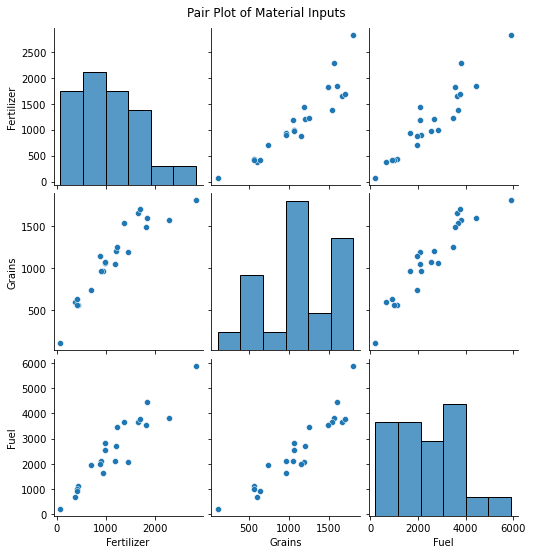

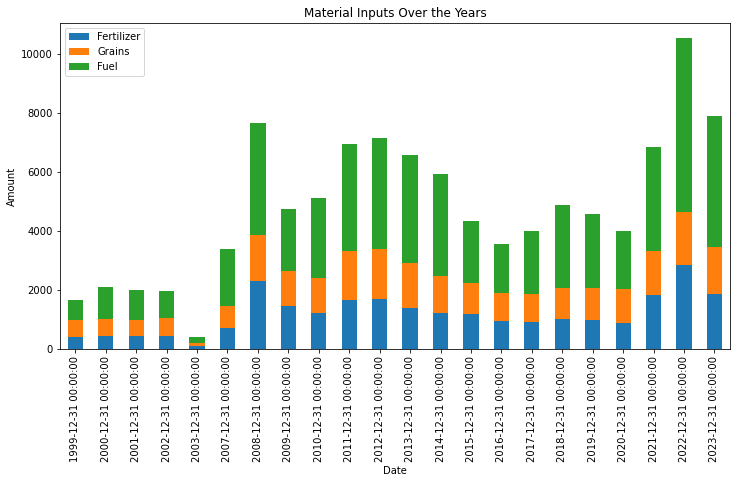

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Date' is in datetime format
df_yearly['Date'] = pd.to_datetime(df_yearly['Date'])

# Basic Statistics
print("Basic Statistics:")
print(df_yearly.describe())

# Correlation Matrix
correlation_matrix = df_yearly.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

# Box Plots for Material Inputs
df_yearly_materials=df_yearly.drop(columns='Date')
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_yearly_materials, width=0.8)
plt.title('Distribution of Material Inputs')
plt.ylabel('Amount')
plt.show()

# Scatter plots for selected pairs
sns.pairplot(df_yearly[['Fertilizer', 'Grains', 'Fuel']])
plt.suptitle('Pair Plot of Material Inputs', y=1.02)
plt.show()

# Bar plot for Material Inputs Over the Years
df_yearly_materials = df_yearly.copy()
df_yearly_materials.set_index('Date', inplace=True)
df_yearly_materials.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Material Inputs Over the Years')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.show()




## Checking for stationarity and Modeling

### Fertilizer

In [11]:
df_fert.set_index('Date', inplace=True)
df_fert.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2023-12-31 to 1999-01-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   300 non-null    float64
dtypes: float64(1)
memory usage: 4.7 KB


#### Checking for stationarity

In [12]:
#The Augmented Dickey-Fuller test for stationarity on the filled dataset
df_fert.index = pd.to_datetime(df_fert.index)
adf_test_result_filled = adfuller(df_fert)

# Extracting the p-value from the test results
adf_p_value_filled = adf_test_result_filled[1]

adf_p_value_filled


0.07060497486697472

Given the ad fuller p-value is greater than 0.05(0.0706) then we can't reject the null hypothesis showing that our data is not stationary. We shall do some decomposition.

5.054134030165399e-06


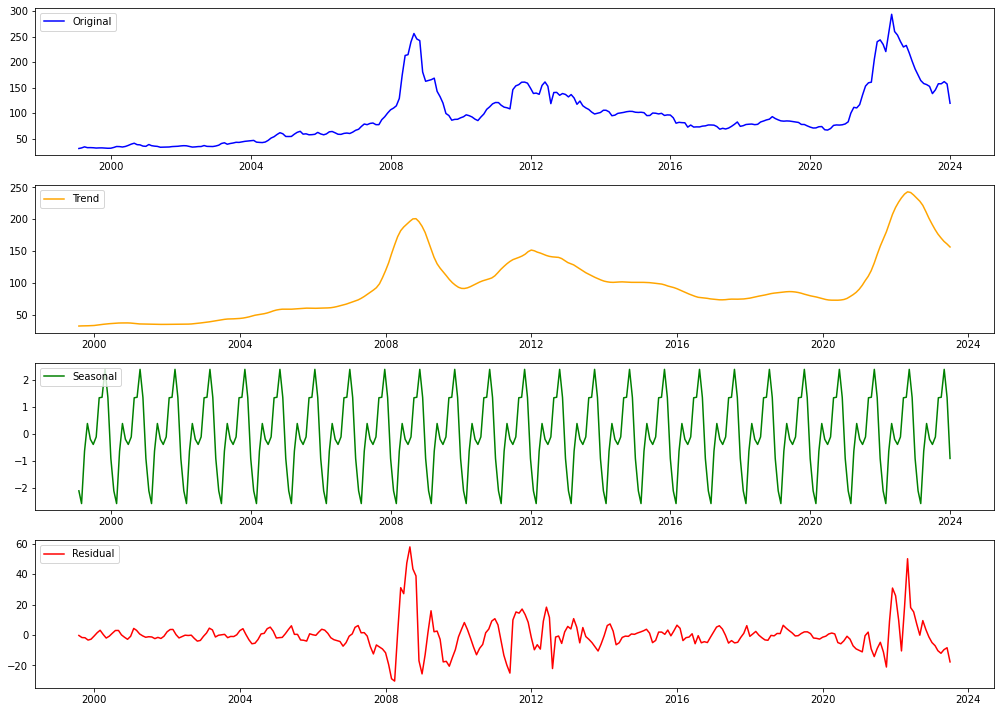

In [13]:

# Seasonality and trend analysis using seasonal decomposition
df_fert_diff=df_fert.diff().dropna()
decomposition = seasonal_decompose(df_fert,model='additive') 

# Performing the Augmented Dickey-Fuller test again on the differenced data
adf_test_result_diff = adfuller(df_fert_diff)
adf_p_value_diff = adf_test_result_diff[1]
print(adf_p_value_diff)

# Plotting the original series, trend, seasonal, and residual components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(df_fert, label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()


With new and improved ad fuller p-value of 0.000005 then the data is now stationary, we can proceed to modelling 

In [14]:
df_fert_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 299 entries, 2023-11-30 to 1999-01-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   299 non-null    float64
dtypes: float64(1)
memory usage: 4.7 KB


#### Modelling

In [15]:
# Splitting our dataset into training and testing sets
# We'll use 80% of the data for training and 20% for testing
train_size = int(len(df_fert_diff) * 0.8)
train_data, test_data = df_fert_diff[0:train_size], df_fert_diff[train_size:]

# Checking the sizes of the training and testing sets
train_data_size = train_data.shape[0]
test_data_size = test_data.shape[0]

train_data_size, test_data_size

(239, 60)

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 239 entries, 2023-11-30 to 2004-01-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   239 non-null    float64
dtypes: float64(1)
memory usage: 3.7 KB


C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1M will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1M will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\statsmod

Root Mean Squared Error (RMSE): 1.7779440229341434


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

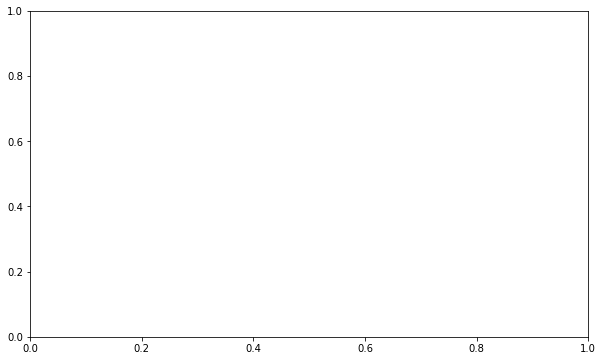

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# Fit ARIMA model on training data
order = (5, 1, 0)  
model = ARIMA(train_data, order=order)
model_fit = model.fit()

# Forecast using the fitted model
predictions = model_fit.forecast(steps=len(test_data))

# Evaluate performance using RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, predictions, label='Predicted', color='red')
plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.show()
